## Final Youtube Comment Analysis

Now that we've established the method for determining sentiment, let's move into the data we actually care about measuring--YouTube comments

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer # rule/lexicon-based sentiment analyzer
import os
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import pandas as pd
import pickle
from math import trunc

# supress warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# slklearn imports
from sklearn.feature_extraction.text import HashingVectorizer # alternative to tf-idf vectorizer
from sklearn.pipeline import Pipeline

# local import
from comment_scraper import get_sql_table

## Get Some Scraped Youtube Comment Data

This initial dataset contains several popular videos from the MSNBC Youtube channel. Channel information had to be scraped to get a list of video ids for popular (e.g. high like count) videos that had a reasonable number of comments (kept running into issues scraping to much data for the api limit.)

In [3]:
# database path information
DATA_DIR = 'C:\\Users\\keatu\\Regis_archive\\practicum2_data\\'
dbname = os.path.join(DATA_DIR, "Youtube_Data_msnbc.db")


In [4]:
# the videos table contains useful information scraped from a channel's youtube page
videos = get_sql_table('videos',dbname)
videos = videos.replace("nan",0)

In [5]:
videos.drop(columns="index").head()

,channelId,channelTitle,description,publishedAt,title,videoId,commentCount,favoriteCount,likeCount,viewCount
0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,"Jeh Johnson, Secretary of Homeland Security un...",2022-07-28T03:00:14Z,'There's Enough Evidence To Prosecute Trump' S...,k8tIAcw0JSM,158,0,447,13203
1,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,"Since Jan. 6, Trump and his allies have repeat...",2022-07-28T02:30:12Z,Secretary Miller’s Testimony Debunks Lie Pushe...,pkpAay83rO4,303,0,1049,25046
2,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,The Indiana doctor who made headlines for prov...,2022-07-28T02:15:01Z,Dr. Who Provided 10-Year-Old With Abortion Car...,jV9WQxNRkUg,85,0,131,2281
3,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,Capitol Hill has its share of Trump loyalists....,2022-07-28T02:00:04Z,Understanding Trump's Army Of Capitol Hill Ena...,B5kdHHJP8Js,176,0,612,17075
4,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,New signs Rupert Murdoch’s media empire is tur...,2022-07-28T01:30:04Z,See Trump's Living Fox News Nightmare: Murdoch...,WWq9j01aEsc,548,0,2545,75638


In [6]:
# comments table
comments = get_sql_table('comments', dbname)
comments = comments.replace("nan",0)

In [7]:
comments.drop(columns="index").head()

,authorDisplayName,canRate,commentId,likeCount,publishedAt,textDisplay,textOriginal,updatedAt,videoId,viewerRating
0,Acer Maximinus,1.0,UgwoNLyVS1kdhoTEsPR4AaABAg,665,2022-07-28T01:19:43Z,It’s so great that the every news cycle isn’t ...,It’s so great that the every news cycle isn’t ...,2022-07-28T01:19:43Z,xXtHUP0LSpM,none
1,James Smith,1.0,UgxJsToTUvYHCH8J1qF4AaABAg,613,2022-07-28T01:13:43Z,It’s actually nice watching someone like Trump...,It’s actually nice watching someone like Trump...,2022-07-28T01:13:43Z,xXtHUP0LSpM,none
2,AskMississippi AskMississippi,1.0,Ugx75sL2in-d9O1nnPN4AaABAg,446,2022-07-28T01:04:31Z,“My political ideal is democracy. Let every pe...,“My political ideal is democracy. Let every pe...,2022-07-28T01:04:31Z,xXtHUP0LSpM,none
3,JustTrollingAlong,1.0,UgxFK_Dv72ynAZtlZOd4AaABAg,248,2022-07-28T01:28:50Z,If Trump and Ted Bundy got together and had a ...,If Trump and Ted Bundy got together and had a ...,2022-07-28T01:28:50Z,xXtHUP0LSpM,none
4,Cadiz King,1.0,UgzDn10hD2NXaQmiAwR4AaABAg,455,2022-07-28T01:05:31Z,Trump for Prison.,Trump for Prison.,2022-07-28T01:05:31Z,xXtHUP0LSpM,none


In [8]:
# join video information with comment information
combined = comments.merge(videos, on='videoId', how="inner", suffixes=("","_video"))
# Take the 10 most popular videos using likeCount
top_videos = combined.groupby("videoId").aggregate({"likeCount_video":"first"}).reset_index().sort_values('likeCount_video', ascending=False).head(10)['videoId'].tolist()
topdf = combined.loc[combined['videoId'].isin(top_videos)]

In [9]:
print(len(topdf))

5452


## Do Some Text Classification

In [10]:
# load the NBmodel
model_file = os.path.join(DATA_DIR,"resources","bernoullinb_model.sav")
with open(model_file, 'rb') as f:
   nb_model = pickle.load(f)

# initalize NLTK VADER model
sia = SentimentIntensityAnalyzer()

# setup preprocessing pipeline for the model
estimators=[('vectorizer',
    HashingVectorizer(
        ngram_range=(1,2),
        n_features=2**25,
        binary = True))]
pipeline = Pipeline(estimators)

In [11]:
# Test out on one video
testdf= topdf.loc[topdf["videoId"]=="ZEuVKKnRbcQ"]
print("Total comments: {}".format(len(testdf)))
print("Video Title: {}".format(testdf['title'].unique()[0]))

Total comments: 495
Video Title: Indicted Trump Coup Plotter Runs From Voting Machine Plot He Admitted


In [12]:
# preprocess the text with our HashingVectorizer parameters
input_text = testdf["textOriginal"]
proc_text = pipeline.fit_transform(input_text)

In [13]:
testdf["nb_score"] = nb_model.predict(proc_text)
testdf["vader_score"] = testdf["textOriginal"].apply(lambda x: sia.polarity_scores(x)['compound'])

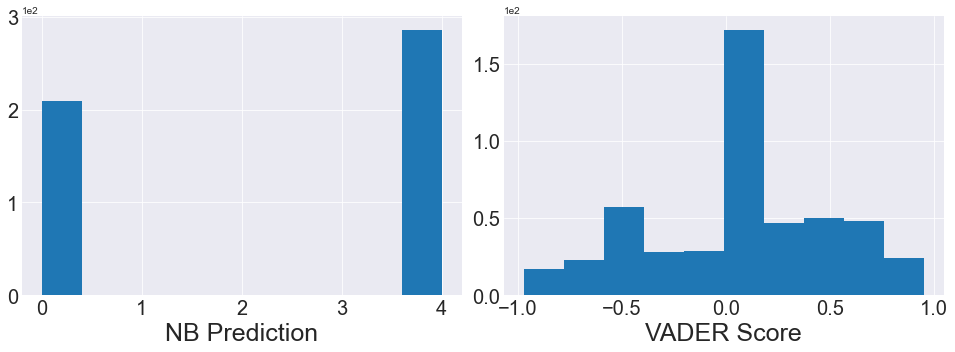

In [14]:
# Plot compare sentiment 
fig = plt.figure(figsize = (20,5))

ax1 = fig.add_subplot(131)
ax1.set_xlabel("NB Prediction", size = 25)
ax1.hist(testdf["nb_score"])

ax2 = fig.add_subplot(132)
ax2.hist(testdf['vader_score'])
ax2.set_xlabel("VADER Score", size = 25)

for ax in (ax1,ax2):
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()


In [16]:
# assume that like count adds to the users expressing that sentiment
vader_scores = []
nb_scores = []
for i,row in testdf[["vader_score","nb_score","likeCount"]].iterrows():
    like_int = row['likeCount']
    vader_scores.extend([row["vader_score"]]*trunc(like_int+1))
    nb_scores.extend([row["nb_score"]]*trunc(like_int+1))


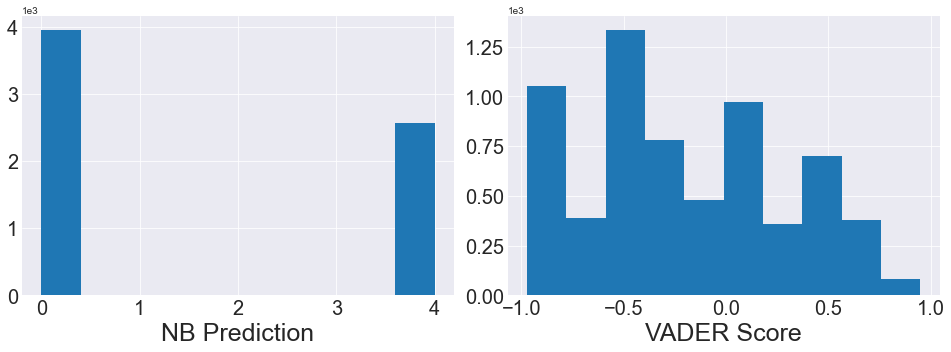

In [17]:
# Plot compare sentiment 
fig = plt.figure(figsize = (20,5))

ax1 = fig.add_subplot(131)
ax1.set_xlabel("NB Prediction", size = 25)
ax1.hist(nb_scores)

ax2 = fig.add_subplot(132)
ax2.hist(vader_scores)
ax2.set_xlabel("VADER Score", size = 25)

for ax in (ax1,ax2):
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()

This completely flips the original results--insinuating that negative comments are the most popular.
The comments are sorted by Youtube's definition of "relevance", which generally consist of highly liked comments--let's take a look at those numbers

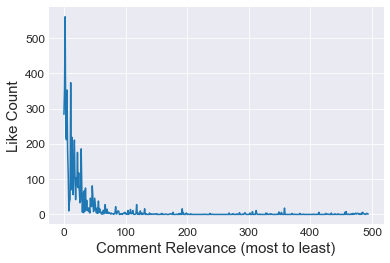

In [29]:
fig, ax = plt.subplots()
ax.plot(testdf['index'],testdf['likeCount'])
ax.set_xlabel("Comment Relevance (most to least)",size = 15)
ax.set_ylabel("Like Count",size = 15)
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#### Sniff test

In [50]:
cols = ['textOriginal','nb_score','vader_score']
testdf.sort_values(['nb_score','vader_score'], ascending=False)[cols].head(10)

,textOriginal,nb_score,vader_score
34637,Ohhhh narravo? Is that wise ?once you deny rec...,4,0.9479
34816,16 For God so loved the world that He gave His...,4,0.9367
34585,I love how some of these higher echelon bums a...,4,0.9201
34526,I love you Ari! You cut to the chase. You're p...,4,0.9114
34562,That's funny. Military voted for Biden big.\n...,4,0.8928
34546,Love the way you report very simple to underst...,4,0.8877
34652,Typical of Trump to ask for money donations af...,4,0.8718
34538,This is all so delicious to take in. The J6 C...,4,0.8570
34831,Love Trump And God bless Donald Trump.,4,0.8442
34828,"So funny ,I guess Peter Pan is a true story as...",4,0.8389


In [52]:
testdf.sort_values(['nb_score','vader_score'], ascending=False)[cols].head(10)['textOriginal'].values

array(['Ohhhh narravo? Is that wise ?once you deny recongize the law of the land ! I pray justice get you real good ! No changing no chance  once you refused ! Good luck! We Americans go behind justice',
       '16 For God so loved the world that He gave His only begotten Son, that whoever believes in Him should not perish but have everlasting life. 17 For God did not send His Son into the world to condemn the world, but that the world through Him might be saved.\n\n\n\n18 “He who believes in Him is not condemned; but he who does not believe is condemned already, because he has not believed in the name of the only begotten Son of God. John 3:16-18 NKJV',
       'I love how some of these higher echelon bums are giving their best renditions of Sergeant Schultz on the old "Hogan\'s Heros" show  "I know nothing, Noth-inng"  Totally forgetting the virtual MILES of tape recorded information to the contrary.',
       "I love you Ari! You cut to the chase. You're persistent about getting to th

Seems ok for the most part--but I can see a decent amount of sarcasm in these comments. This was a major issue in the VADER package, so perhaps using these as a benchmark for positive comments is not a good idea.

In [59]:
testdf.loc[testdf['nb_score']==4].sample(10)['textOriginal'].values

array(["They'll both seek appeals that will push off their days of reckoning until the next GOP president issues them pardons.",
       'I think that powerpoint they made should be more than enough evidenve',
       'Mango Mussolini is going to prison, amen!',
       "That's the problem with our justice system. Offering people that disregard the law a plea deal. Do your job and prosecute these traitors.",
       'How many family members did Cheney have to threaten?',
       'Ari, your coverage of ‘your friend’ Navarro is illuminating. I truly believe he forgot that for all intents and purpose he admitted guilt on your show',
       'Ari, you and your folks do great,honest work. Thanks for supporting our democracy.',
       'I love the "role the tape" moments.',
       'President Biden is remarkable',
       "trump's motley Crew  are going down"], dtype=object)

In [55]:
testdf.sort_values(['nb_score','vader_score'])[cols].head(10)['textOriginal'].values

array(['Anybody caught lying to the January 6th committee should and must lose all government pensions they would be due to them for contempt  they should lose any other perks. They should face a long prison terms as a warning they will lose everything for abusing their office. They should never be allowed to stand for public office ever again.',
       "I wouldn't have offered Navarro a plea deal anyway. He needs to be tossed in prison and not some fancy federal prison. While there, he can be charged and convicted again, so he can spend the rest of his life in prison thinking about what he did. I don't see why our government keeps playing with these people, throw the book at them and lock them up!",
       'So, 5 years for contempt, assuming the maximum.  Or, 20 years for plotting a coup and being hated and probably never getting a day early... tough choice',
       "I see much disappointment in Trump's Rep's future , sad so gullible ....",
       'These guys said things in public, pu

## Go through a bunch of videos from MSNBC

In [54]:
print("Total comments: {}".format(len(combined)))
print("Total videos: {}".format(combined['videoId'].nunique()))

Total comments: 188516
Total videos: 519


In [51]:
# apply same model preprocessing/classifcation steps
input_text = combined["textOriginal"]
print("vectorizing the text")
proc_text = pipeline.fit_transform(input_text)
print("scoring with naive bayes model")
combined["nb_score"] = nb_model.predict(proc_text)
print("scoring with vader")
combined["vader_score"] = combined["textOriginal"].apply(lambda x: sia.polarity_scores(x)['compound'])

vectorizing the text
scoring with naive bayes model
scoring with vader


In [56]:

for vidId,grp in combined.groupby("videoId"):
    

-9GIpOgGLz8
339
